In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breakhis-breast-cancer-histopathological-dataset/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-29960CD-200-012.png
/kaggle/input/breakhis-breast-cancer-histopathological-dataset/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-22549AB-200-029.png
/kaggle/input/breakhis-breast-cancer-histopathological-dataset/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-22549AB-200-010.png
/kaggle/input/breakhis-breast-cancer-histopathological-dataset/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-22549CD-200-018.png
/kaggle/input/breakhis-breast-cancer-histopathological-dataset/BreakHis - Breast Cancer Histopathological Databa

In [2]:
# Imports and config
import os, re, glob, random, itertools, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Make TF behave well on Kaggle GPUs
tf.config.optimizer.set_jit(False)

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Root of the Kaggle dataset
DATA_ROOT = "/kaggle/input/breakhis-breast-cancer-histopathological-dataset/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1/dataset_cancer_v1/classificacao_binaria"

# Use all magnifications; or restrict, e.g.: ["40X", "100X"]
USE_MAGS = ["40X","100X","200X","400X"]  # case-insensitive

IMG_SIZE   = (299, 299)
BATCH_SIZE = 32
LR_1 = 3e-4          # frozen phase
LR_2 = 5e-5          # fine-tune phase
EPOCHS_FROZEN   = 5
EPOCHS_UNFROZEN = 10

2025-08-13 22:51:15.176665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755125475.374471      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755125475.428592      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Find all image files under benign/malignant across magnifications
EXTS = ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")

def list_images(root):
    files = []
    for ext in EXTS:
        files += glob.glob(os.path.join(root, "**", ext), recursive=True)
    return sorted(files)

def is_mag_ok(p):
    pl = p.lower()
    for m in USE_MAGS:
        if (os.sep + m.lower() + os.sep) in pl:
            return True
    # Some dumps put mag like ".../100X/..." others ".../100x/..."; handle both
    for m in USE_MAGS:
        if (os.sep + m.lower().replace("x","") + "x" + os.sep) in pl:
            return True
    return False

def infer_binary_label(p):
    pl = p.lower()
    if os.sep + "benign" + os.sep in pl: return 0
    if os.sep + "malignant" + os.sep in pl: return 1
    return None

def extract_patient_id(p):
    # filenames usually contain patient digits; take the longest digit block
    base = os.path.basename(p)
    digs = re.findall(r"(\d+)", base)
    return max(digs, key=len) if digs else base

def extract_mag(p):
    m = re.search(r"(\d{2,3})x", p.lower())
    return m.group(1) + "X" if m else "UNK"

rows = []
for p in list_images(DATA_ROOT):
    y = infer_binary_label(p)
    if y is None: 
        continue
    if not is_mag_ok(p): 
        continue
    rows.append((p, y, extract_patient_id(p), extract_mag(p)))

df = pd.DataFrame(rows, columns=["path","label","patient_id","magnification"]).reset_index(drop=True)
print("Total images:", len(df), " | patients:", df["patient_id"].nunique())
print("Class counts (0=benign,1=malignant):\n", df["label"].value_counts().sort_index())
print("Magnifications:", df["magnification"].value_counts().sort_index())

Total images: 7909  | patients: 70
Class counts (0=benign,1=malignant):
 label
0    2480
1    5429
Name: count, dtype: int64
Magnifications: magnification
100X    2081
200X    2013
400X    1820
40X     1995
Name: count, dtype: int64


In [4]:
# Patient-wise split
def split_binary_patientwise(df, val_frac=0.15, test_frac=0.15, max_tries=200, seed=SEED):
    X = np.arange(len(df)); y = df["label"].values; g = df["patient_id"].values

    def one(rs):
        # Holdout TEST
        n1 = max(3, int(round(1/max(test_frac,1e-6))))
        sgkf1 = StratifiedGroupKFold(n_splits=n1, shuffle=True, random_state=rs)
        tr, te = next(sgkf1.split(X, y, g))
        df_tv, df_te = df.iloc[tr].reset_index(drop=True), df.iloc[te].reset_index(drop=True)
        # Split TRAIN/VAL inside train+val pool
        rel_val = val_frac/(1-test_frac)
        n2 = max(3, int(round(1/max(rel_val,1e-6))))
        sgkf2 = StratifiedGroupKFold(n_splits=n2, shuffle=True, random_state=rs+123)
        X_tv = np.arange(len(df_tv)); y_tv = df_tv["label"].values; g_tv = df_tv["patient_id"].values
        tr2, va2 = next(sgkf2.split(X_tv, y_tv, g_tv))
        df_tr = df_tv.iloc[tr2].reset_index(drop=True); df_va = df_tv.iloc[va2].reset_index(drop=True)
        return df_tr, df_va, df_te

    for k in range(max_tries):
        df_tr, df_va, df_te = one(seed + 7*k)
        if df_tr["label"].nunique()==2 and df_va["label"].nunique()==2 and df_te["label"].nunique()==2:
            return df_tr, df_va, df_te
    raise RuntimeError("Could not place both classes in all splits; check data or increase max_tries.")

df_train, df_val, df_test = split_binary_patientwise(df, 0.15, 0.15)

def summarize(name, d):
    print(f"{name}: n={len(d):5d}  patients={d['patient_id'].nunique():4d}")
    print(d["label"].value_counts().sort_index(), "\n")

summarize("TRAIN", df_train)
summarize("VAL",   df_val)
summarize("TEST",  df_test)

TRAIN: n= 5890  patients=  52
label
0    1901
1    3989
Name: count, dtype: int64 

VAL: n= 1110  patients=   9
label
0    197
1    913
Name: count, dtype: int64 

TEST: n=  909  patients=   9
label
0    382
1    527
Name: count, dtype: int64 



In [5]:
# Input image visualization
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tensorflow import keras

# df should have at least: ["path", "label"] where label is 0=benign, 1=malignant
# Optional columns (if present) will be shown in the title: ["patient_id", "magnification"]

def show_samples(df, k_per_class=8, shuffle=True, seed=42, target_size=(299,299)):
    """
    Display a grid sampled evenly per class (0=benign, 1=malignant).
    If a class has < k_per_class, it shows as many as available.
    """
    frames = []
    for y in sorted(df["label"].unique()):
        d = df[df["label"] == y]
        k = min(k_per_class, len(d))
        if k > 0:
            frames.append(d.sample(k, random_state=seed))
    if not frames:
        print("No images to display.")
        return
    samp = pd.concat(frames, ignore_index=True)
    if shuffle:
        samp = samp.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    n = len(samp)
    cols = min(6, max(3, int(math.ceil(math.sqrt(n)))))
    rows = math.ceil(n / cols)

    plt.figure(figsize=(3.2*cols, 3.2*rows))
    for i, r in enumerate(samp.itertuples(index=False), 1):
        img = keras.utils.load_img(r.path, target_size=target_size)
        ax = plt.subplot(rows, cols, i)
        plt.imshow(img); plt.axis("off")
        lab = "malignant" if int(r.label) == 1 else "benign"
        pid = getattr(r, "patient_id", "")
        mag = getattr(r, "magnification", "")
        title = lab
        if mag: title += f" • {mag}"
        if pid: title += f"\nPID:{pid}"
        ax.set_title(title, fontsize=9)
    plt.tight_layout(); plt.show()

def show_by_magnification(df, k_per_class=2, seed=42, target_size=(299,299)):
    """One grid per magnification, sampled evenly per class."""
    if "magnification" not in df.columns:
        print("Column 'magnification' not found; showing a single mixed grid.")
        return show_samples(df, k_per_class=k_per_class, seed=seed, target_size=target_size)
    for mag, dmag in df.groupby("magnification"):
        print(f"Magnification: {mag}  (n={len(dmag)})")
        show_samples(dmag, k_per_class=k_per_class, seed=seed, target_size=target_size)

Magnification: 100X  (n=2081)


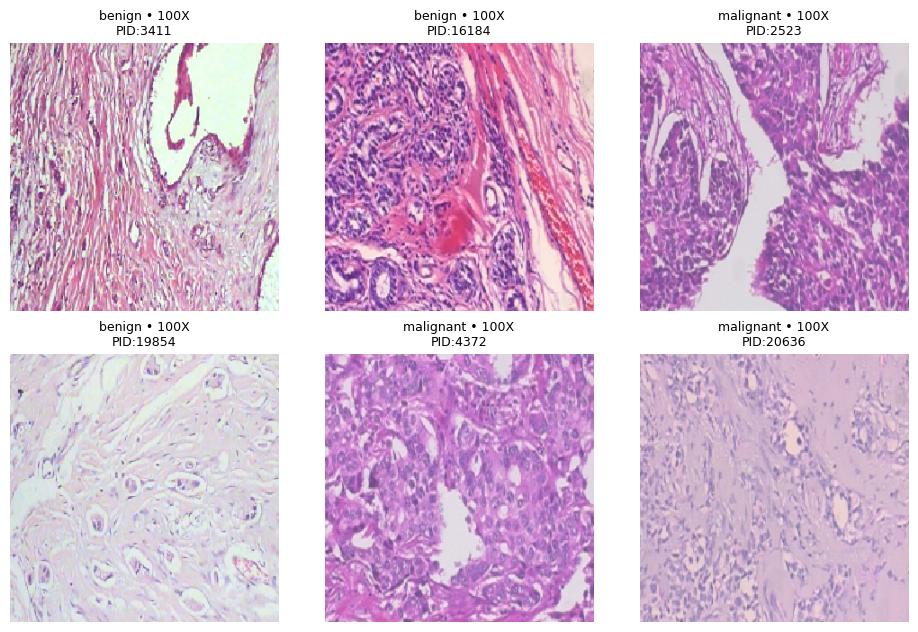

Magnification: 200X  (n=2013)


Magnification: 400X  (n=1820)


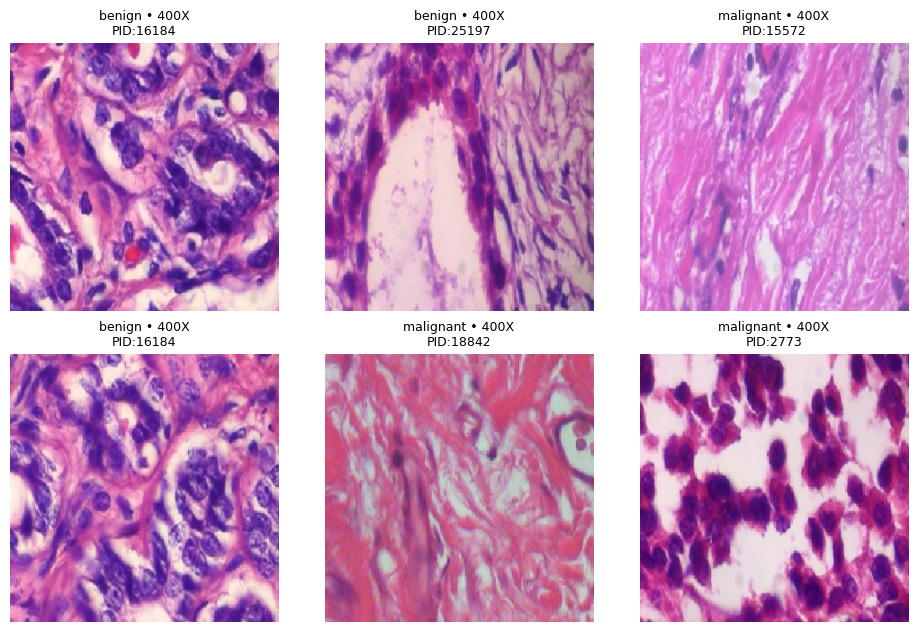

Magnification: 40X  (n=1995)


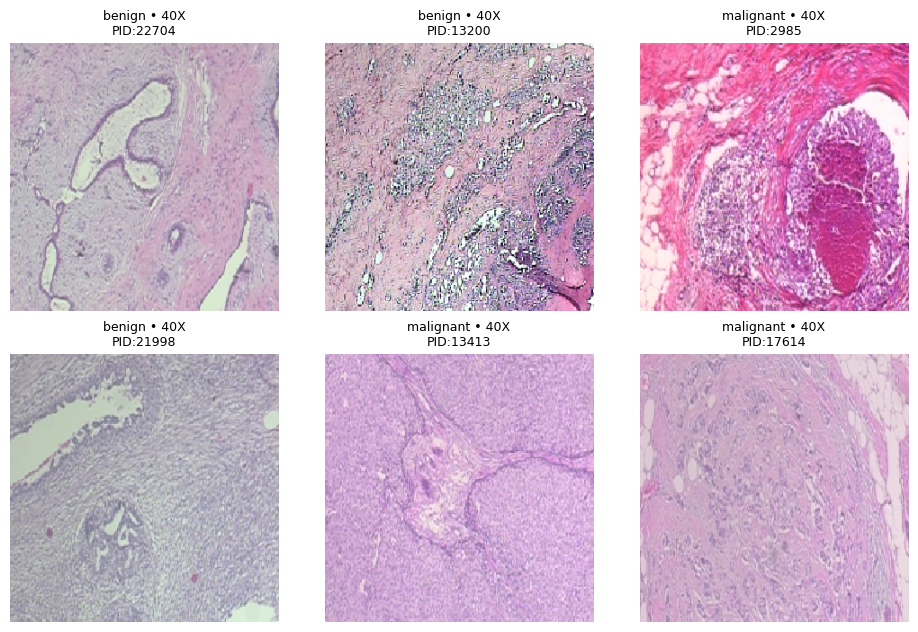

In [6]:
# Balanced grid per magnification:
show_by_magnification(df, k_per_class=3, seed=SEED, target_size=IMG_SIZE)

In [7]:
# Build tf.data
AUTO = tf.data.AUTOTUNE

def preprocess_image(path, y, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    img = tf.cast(img, tf.float32)  # keep 0..255; model will normalize

    if augment:
        # geometric
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        # intensity in [0,1], then back to 0..255 — keeps model as the ONLY normalizer
        f = img / 255.0
        f = tf.image.random_brightness(f, 0.08)
        f = tf.image.random_contrast(f, 0.85, 1.15)
        img = tf.clip_by_value(f, 0.0, 1.0) * 255.0

    return img, tf.cast(y, tf.float32)  # binary label (0/1) as float

def make_eval_ds(df_, batch_size=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((df_["path"].values, df_["label"].values.astype(np.int32)))
    ds = ds.map(lambda p,y: preprocess_image(p,y,augment=False), num_parallel_calls=AUTO)
    return ds.batch(batch_size).prefetch(AUTO)

def make_balanced_train_ds(df_train, batch_size=BATCH_SIZE):
    # Build one dataset per class, repeat+shuffle, then sample equally from both.
    def ds_for(label):
        d = df_train[df_train["label"]==label]
        ds = tf.data.Dataset.from_tensor_slices((d["path"].values, d["label"].values.astype(np.int32)))
        ds = ds.shuffle(len(d), seed=SEED, reshuffle_each_iteration=True).repeat()
        ds = ds.map(lambda p,y: preprocess_image(p,y,augment=True), num_parallel_calls=AUTO)
        return ds
    ds0, ds1 = ds_for(0), ds_for(1)
    mixed = tf.data.Dataset.sample_from_datasets([ds0, ds1], weights=[0.5, 0.5], seed=SEED)
    return mixed.batch(batch_size).prefetch(AUTO)

train_ds = make_balanced_train_ds(df_train, BATCH_SIZE)
val_ds   = make_eval_ds(df_val,   BATCH_SIZE)
test_ds  = make_eval_ds(df_test,  BATCH_SIZE)

I0000 00:00:1755125495.427248      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
# Model and phase-1 training
def build_model():
    eff = keras.applications.efficientnet_v2.EfficientNetV2B0(
        include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,)
    )
    eff.trainable = False
    backbone = keras.Sequential([eff], name="backbone")

    inp = keras.Input(shape=IMG_SIZE+(3,))
    x = keras.applications.efficientnet_v2.preprocess_input(inp)  # single normalizer
    x = backbone(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)   # sturdier head
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(x)  # binary
    return keras.Model(inp, out)

model = build_model()
model.compile(
    optimizer=keras.optimizers.Adam(LR_1),
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.02),
    metrics=["accuracy", keras.metrics.AUC(name="auc")],
    jit_compile=False
)
model.summary()

ckpt1 = keras.callbacks.ModelCheckpoint(
    "bin_phase1.weights.h5", monitor="val_auc",
    save_best_only=True, save_weights_only=True, mode="max", verbose=1
)
early1 = keras.callbacks.EarlyStopping(monitor="val_auc", patience=3, restore_best_weights=True)

hist1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FROZEN,
    steps_per_epoch= math.ceil(len(df_train)/BATCH_SIZE),  # because we used repeat()
    callbacks=[ckpt1, early1],
    verbose=1
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ backbone (Sequential)           │ (None, 10, 10, 1280)   │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,925,713 (22.60 MB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 5,921,872 (22.59 MB)

Epoch 1/5


E0000 00:00:1755125517.394936      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1755125518.876873      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6514 - auc: 0.6975 - loss: 0.7118
Epoch 1: val_auc improved from -inf to 0.73970, saving model to bin_phase1.weights.h5
185/185 ━━━━━━━━━━━━━━━━━━━━ 54s 172ms/step - accuracy: 0.6517 - auc: 0.6979 - loss: 0.7113 - val_accuracy: 0.7982 - val_auc: 0.7397 - val_loss: 0.5268
Epoch 2/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8020 - auc: 0.8708 - loss: 0.4779
Epoch 2: val_auc improved from 0.73970 to 0.76745, saving model to bin_phase1.weights.h5
185/185 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.8021 - auc: 0.8708 - loss: 0.4777 - val_accuracy: 0.7973 - val_auc: 0.7674 - val_loss: 0.5088
Epoch 3/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8170 - auc: 0.8985 - loss: 0.4299
Epoch 3: val_auc improved from 0.76745 to 0.77307, saving model to bin_phase1.weights.h5
185/185 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.8171 - auc: 0.8985 - loss: 0.4298 - val_accuracy: 0.8000 - val_auc: 0.7731 - val_lo

In [9]:
# Phase-2 fine tuning
model.load_weights("bin_phase1.weights.h5")

backbone = model.get_layer("backbone")
inner = backbone.layers[0]   # EfficientNetV2B0

n_total = len(inner.layers)
n_unfreeze = max(1, int(0.30 * n_total))
start = n_total - n_unfreeze

for i, layer in enumerate(inner.layers):
    if i >= start and not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(LR_2),
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.02),
    metrics=["accuracy", keras.metrics.AUC(name="auc")],
    jit_compile=False
)

ckpt2 = keras.callbacks.ModelCheckpoint(
    "bin_phase2.keras", monitor="val_auc",
    save_best_only=True, mode="max", verbose=1
)
early2 = keras.callbacks.EarlyStopping(monitor="val_auc", patience=4, restore_best_weights=True)

hist2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_UNFROZEN,
    steps_per_epoch= math.ceil(len(df_train)/BATCH_SIZE),
    callbacks=[ckpt2, early2],
    verbose=1
)

Epoch 1/10


E0000 00:00:1755125660.374561      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8523 - auc: 0.9305 - loss: 0.3620
Epoch 1: val_auc improved from -inf to 0.77344, saving model to bin_phase2.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 52s 150ms/step - accuracy: 0.8523 - auc: 0.9305 - loss: 0.3619 - val_accuracy: 0.8099 - val_auc: 0.7734 - val_loss: 0.5398
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8856 - auc: 0.9582 - loss: 0.2905
Epoch 2: val_auc improved from 0.77344 to 0.79081, saving model to bin_phase2.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.8856 - auc: 0.9582 - loss: 0.2905 - val_accuracy: 0.8018 - val_auc: 0.7908 - val_loss: 0.5668
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9035 - auc: 0.9646 - loss: 0.2726
Epoch 3: val_auc improved from 0.79081 to 0.81179, saving model to bin_phase2.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.9035 - auc: 0.9646 - loss: 0.2726 - val_accuracy: 0.8703 - val_auc: 0.8118 - val_loss: 0.4555


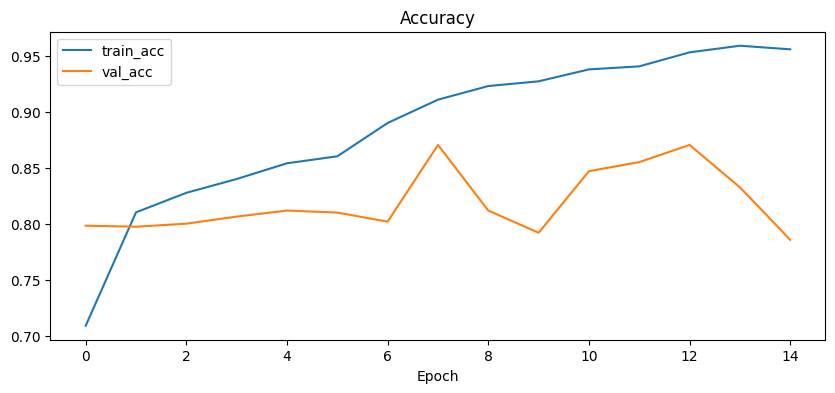

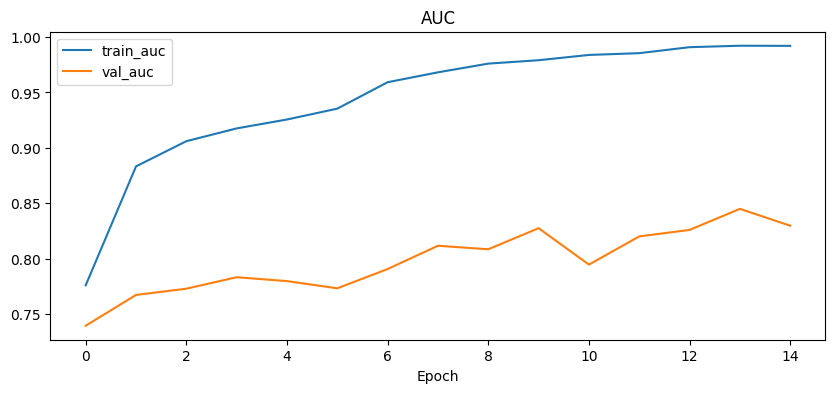

In [10]:
# Plots
def merge_hist(h1,h2):
    keys = set(h1.history.keys()) | set(h2.history.keys())
    return {k: h1.history.get(k, []) + h2.history.get(k, []) for k in keys}

hist = merge_hist(hist1, hist2)
plt.figure(figsize=(10,4)); plt.plot(hist["accuracy"], label="train_acc"); plt.plot(hist["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy"); plt.xlabel("Epoch"); plt.show()
plt.figure(figsize=(10,4)); plt.plot(hist["auc"], label="train_auc"); plt.plot(hist["val_auc"], label="val_auc")
plt.legend(); plt.title("AUC"); plt.xlabel("Epoch"); plt.show()

AUC: 0.8473181199519159
PR-AUC (malignant): 0.8891743675857332

Classification report (0=benign,1=malignant):
              precision    recall  f1-score   support

      benign     0.7356    0.6702    0.7014       382
   malignant     0.7754    0.8254    0.7996       527

    accuracy                         0.7602       909
   macro avg     0.7555    0.7478    0.7505       909
weighted avg     0.7587    0.7602    0.7583       909



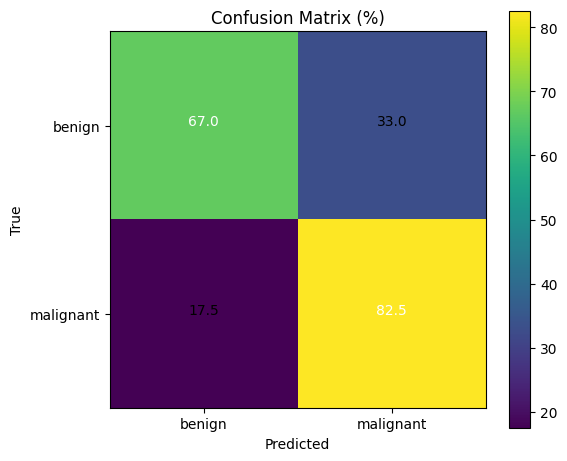


Patient-level classification report:
              precision    recall  f1-score   support

      benign     0.6667    1.0000    0.8000         2
   malignant     1.0000    0.8571    0.9231         7

    accuracy                         0.8889         9
   macro avg     0.8333    0.9286    0.8615         9
weighted avg     0.9259    0.8889    0.8957         9

Patient-level AUC: 0.9285714285714286


In [11]:
# Test evaluation (binary and patient-level)

# Batch-level metrics
y_true, y_prob = [], []
for xb, yb in test_ds:
    p = model.predict(xb, verbose=0).ravel()
    y_prob.extend(p); y_true.extend(yb.numpy().ravel())

y_true = np.array(y_true, dtype=int)
y_prob = np.array(y_prob, dtype=float)
y_pred = (y_prob >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_true, y_prob))
print("PR-AUC (malignant):", average_precision_score(y_true, y_prob))
print("\nClassification report (0=benign,1=malignant):")
print(classification_report(y_true, y_pred, target_names=["benign","malignant"], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
cmn = cm.astype(np.float32) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

def plot_cm(M, names, normalize=True):
    plt.figure(figsize=(6,5))
    X = M*100 if normalize else M
    plt.imshow(X, interpolation='nearest'); plt.title("Confusion Matrix" + (" (%)" if normalize else ""))
    plt.colorbar()
    ticks = np.arange(len(names)); plt.xticks(ticks, names); plt.yticks(ticks, names)
    th = (X.max()+X.min())/2.0
    for i,j in itertools.product(range(X.shape[0]), range(X.shape[1])):
        txt = f"{X[i,j]:.1f}" if normalize else str(int(X[i,j]))
        plt.text(j,i,txt,ha="center", color="white" if X[i,j]>th else "black")
    plt.ylabel("True"); plt.xlabel("Predicted"); plt.tight_layout(); plt.show()

plot_cm(cmn, ["benign","malignant"], normalize=True)

# Patient-level majority vote
df_te = df_test[["path","patient_id","label"]].reset_index(drop=True)
plain = tf.data.Dataset.from_tensor_slices((df_te["path"].values, df_te["label"].values.astype(np.int32)))
plain = plain.map(lambda p,y: preprocess_image(p,y,augment=False), num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
probs = []
for xb, _ in plain:
    probs.extend(model.predict(xb, verbose=0).ravel())
df_te["prob_malig"] = np.array(probs)
df_te["pred"] = (df_te["prob_malig"] >= 0.5).astype(int)

pat_true = df_te.groupby("patient_id")["label"].agg(lambda x: int(np.round(x.mean()))).values
pat_pred = df_te.groupby("patient_id")["pred"].agg(lambda x: int(np.round(x.mean()))).values
print("\nPatient-level classification report:")
print(classification_report(pat_true, pat_pred, target_names=["benign","malignant"], digits=4))
print("Patient-level AUC:", roc_auc_score(
    (df_te.groupby("patient_id")["label"].mean()>0.5).astype(int),
    df_te.groupby("patient_id")["prob_malig"].mean()
))

In [12]:
# Load best checkpoint (already the best by val AUC)
# model already in memory from training

# Pick threshold on VAL (Youden’s J) and save it
from sklearn.metrics import roc_curve
y_val, p_val = [], []
for xb, yb in val_ds:
    p_val += model.predict(xb, verbose=0).ravel().tolist()
    y_val += yb.numpy().astype(int).tolist()
fpr, tpr, thr = roc_curve(y_val, p_val)
best_thr = float(thr[(tpr - fpr).argmax()])
print("Chosen threshold:", best_thr)

import numpy as np, json, os
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/threshold.json","w") as f: json.dump({"threshold":best_thr}, f)

# Final test metrics with that threshold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
y_true, p_test = [], []
for xb, yb in test_ds:
    p_test += model.predict(xb, verbose=0).ravel().tolist()
    y_true += yb.numpy().astype(int).tolist()
y_pred = (np.array(p_test) >= best_thr).astype(int)

print("Test AUC:", roc_auc_score(y_true, p_test))
print("Test PR-AUC:", average_precision_score(y_true, p_test))
print(classification_report(y_true, y_pred, target_names=["benign","malignant"], digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# Save the model
model.save("artifacts/breakhis_binary_efficientnetv2.keras")

Chosen threshold: 0.26916438341140747
Test AUC: 0.8473181199519159
Test PR-AUC: 0.8891743675857332
              precision    recall  f1-score   support

      benign     0.7631    0.5733    0.6547       382
   malignant     0.7379    0.8710    0.7990       527

    accuracy                         0.7459       909
   macro avg     0.7505    0.7221    0.7268       909
weighted avg     0.7485    0.7459    0.7383       909

Confusion matrix:
 [[219 163]
 [ 68 459]]
